In [0]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-18 21:53:47--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.1’

mnist_test_seq.npy. 100%[===================>] 781.25M  29.8MB/s    in 27s     

2020-05-18 21:54:14 (28.7 MB/s) - ‘mnist_test_seq.npy.1’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_addons as tfa
import math as ma
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3
np.set_printoptions(precision=2)

In [0]:
# Data processing
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:500, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
train_data = data[:450, :, :, :]
val_data = data[450:, :, :, :]
train_data = train_data/np.max(data)
val_data = val_data/np.max(data)
N, F, H, W, C = data.shape # dims
print('dataset = '+str(data.shape)) # shape is [instance x frame x height x width x channel]

dataset = (500, 20, 64, 64, 1)


In [0]:
def MCNet_data(data, cutoff):
  X = data[:, :cutoff, :, :, :]
  y_MCNet = data[:, cutoff, :, :, :]
  X_MCNet_content = X[:, -1, :, :, :]
  # X_MCNet_motion = X[:, 1:, :, :, :] - X[:, :-1, :, :, :]
  X_MCNet_motion = X[:, :-1, :, :, :]
  return X_MCNet_motion, X_MCNet_content, y_MCNet
init_traj = 10
X_MCNet_motion, X_MCNet_content, y_MCNet = MCNet_data(train_data, init_traj)
X_val_MCNet_motion, X_val_MCNet_content, y_val_MCNet = MCNet_data(val_data, init_traj)
print("X_MCNet_motion is:", X_MCNet_motion.shape)
print("X_MCNet_content is:", X_MCNet_content.shape)
print("y_MCNet is:", y_MCNet.shape)
X_MCNet_motion = tf.cast(X_MCNet_motion, tf.float32)
X_MCNet_content = tf.cast(X_MCNet_content, tf.float32)
y_MCNet = tf.cast(y_MCNet, tf.float32)
X_val_MCNet_motion = tf.cast(X_val_MCNet_motion, tf.float32)
X_val_MCNet_content = tf.cast(X_val_MCNet_content, tf.float32)
y_val_MCNet = tf.cast(y_val_MCNet, tf.float32)

X_MCNet_motion is: (450, 9, 64, 64, 1)
X_MCNet_content is: (450, 64, 64, 1)
y_MCNet is: (450, 64, 64, 1)


In [0]:
# Custom metrics: SSIM, PSNR, POD, FAR

def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [0]:
# Custom Loss
def mse_modified(y_gt, y_pred, max_val=.1):
  y_gt_pred_eq = tf.math.equal(y_gt, y_pred)
  y_pred_0 = tf.math.equal(y_pred, 0)
  y_both_0 = tf.math.logical_and(y_gt_pred_eq, y_pred_0)
  num_both_0 = tf.math.count_nonzero(y_both_0, dtype=tf.dtypes.float32)
  size_y = tf.size(y_gt, out_type=tf.dtypes.float32)
  return tf.keras.losses.MSE(y_gt, y_pred)*size_y/(size_y - num_both_0 + 1)


def ssim_loss(y_gt, y_pred, max_val=1.):
  return 1-tf.math.reduce_mean(tf.image.ssim(y_gt, y_pred, max_val))

def mse_mae_ssim_loss(y_gt, y_pred, max_val=1.):
  return ssim_loss(y_gt, y_pred, max_val) + \
         tf.keras.losses.MSE(y_gt, y_pred) + \
         tf.keras.losses.MAE(y_gt, y_pred)

def mse_binary_crossentropy(y_gt, y_pred, max_val=1.):
  return tf.keras.losses.MSE(y_gt, y_pred) + tf.keras.losses.binary_crossentropy(y_gt, y_pred)

In [0]:
# Our Model Architecture
def model_init():
    inputs_motion = tf.keras.Input(shape=[None, H, W, C])
    inputs_content = tf.keras.Input(shape=[H, W, C])

    inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, input_shape=[2*H, 2*W, 3])
    inceptionv3.trainable = False

    l2_reg = tf.keras.regularizers.l2(l=0.001)

    # Motion Encoder
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(3, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg))(inputs_motion)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.UpSampling2D(size=(2,2)))(x)
    x = tf.keras.layers.TimeDistributed(inceptionv3)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Reshape((8,8,-1)))(x)
    ME = tf.keras.layers.ConvLSTM2D(128, (7,7), activation='relu', padding='same', return_sequences=False, kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)

    # Content Encoder
    x = tf.keras.layers.Conv2D(3, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(inputs_content)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D(size=(2,2))(x)
    CE = inceptionv3(x)
    x = tf.keras.layers.BatchNormalization()(x)
    CE = tf.keras.layers.Reshape((8,8,128))(CE)

    # Combination layers
    concat = tf.keras.layers.Concatenate()([CE, ME])
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(concat)
    x = tf.keras.layers.BatchNormalization()(x)

    # Decoder layers
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x) #new
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x) #new
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Prediction
    preds = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', padding='same', kernel_regularizer=l2_reg)(x) #sigmoid original
    return tf.keras.Model(inputs=[inputs_motion, inputs_content], outputs=preds)

In [0]:
# Learning rate step decay
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * ma.pow(drop, ma.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [0]:
fl = tfa.losses.SigmoidFocalCrossEntropy()
model = model_init()
# Build optimizer
callbacks_list = [lrate]
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc', 'mse', 'binary_crossentropy',
                       ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP')])
# Fit the model
history = model.fit([X_MCNet_motion, X_MCNet_content], y_MCNet, batch_size=30, epochs=200, validation_split=0.1)


Epoch 1/200
14/14 [==============================] - 13s 917ms/step - loss: 5.6863 - acc: 0.5464 - mse: 0.2551 - binary_crossentropy: 0.8022 - ssim: 0.0030 - psnr: 6.4850 - cor: 0.0356 - prec: 0.0809 - recall: 0.4726 - FN: 62504.0000 - FP: 635995.0000 - TN: 904364.0000 - TP: 56017.0000 - val_loss: 9.2430 - val_acc: 0.0806 - val_mse: 0.8374 - val_binary_crossentropy: 4.7411 - val_ssim: 0.0013 - val_psnr: 0.7718 - val_cor: 0.0824 - val_prec: 0.0796 - val_recall: 1.0000 - val_FN: 0.0000e+00 - val_FP: 156488.0000 - val_TN: 14294.0000 - val_TP: 13538.0000
Epoch 2/200
14/14 [==============================] - 9s 659ms/step - loss: 4.6786 - acc: 0.8362 - mse: 0.1888 - binary_crossentropy: 0.5825 - ssim: 0.0023 - psnr: 7.2712 - cor: 0.1120 - prec: 0.1182 - recall: 0.1739 - FN: 97911.0000 - FP: 153805.0000 - TN: 1386554.0000 - TP: 20610.0000 - val_loss: 5.6220 - val_acc: 0.0691 - val_mse: 0.6896 - val_binary_crossentropy: 2.0373 - val_ssim: 0.0015 - val_psnr: 1.6179 - val_cor: 0.1050 - val_prec:

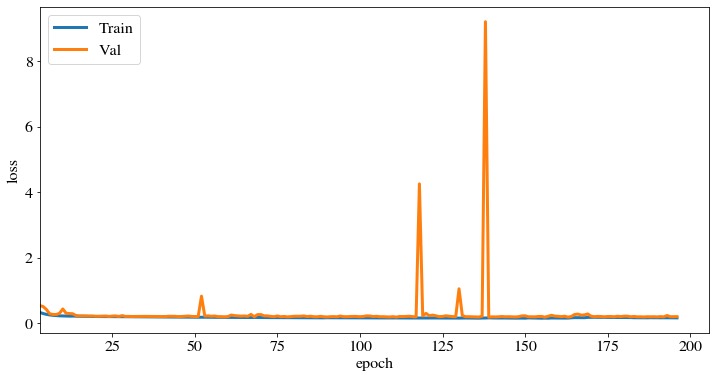

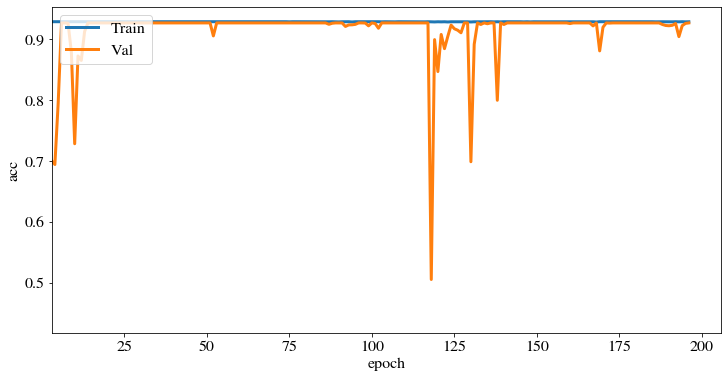

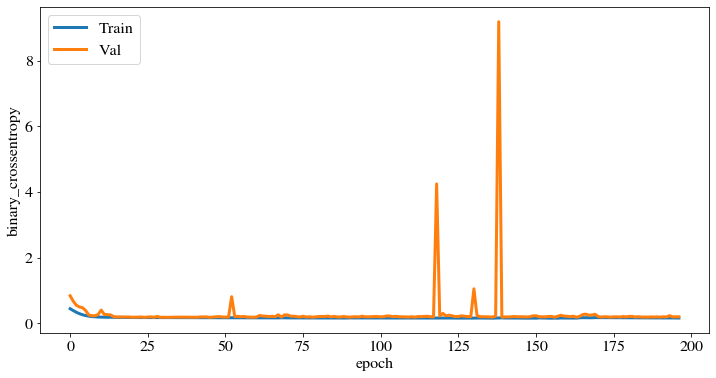

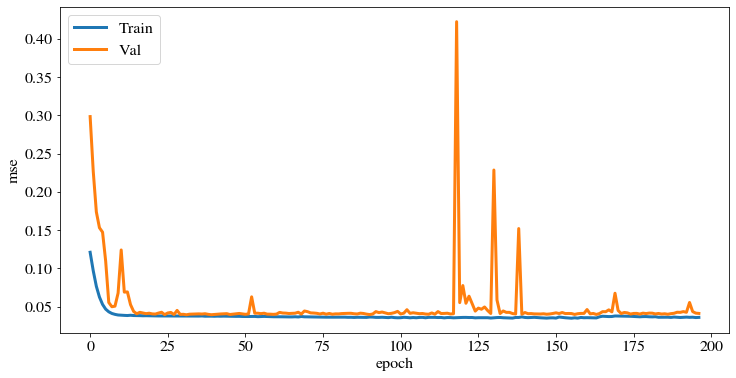

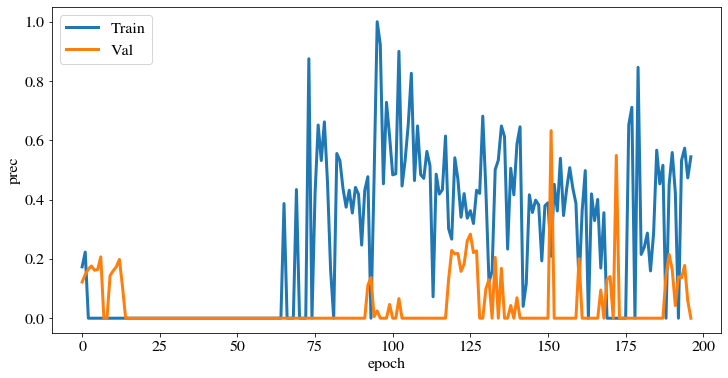

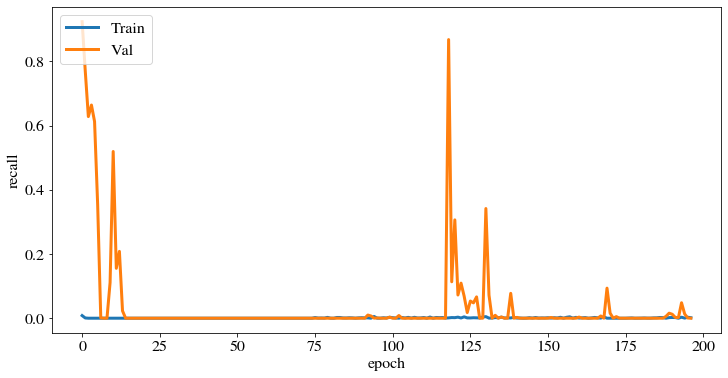

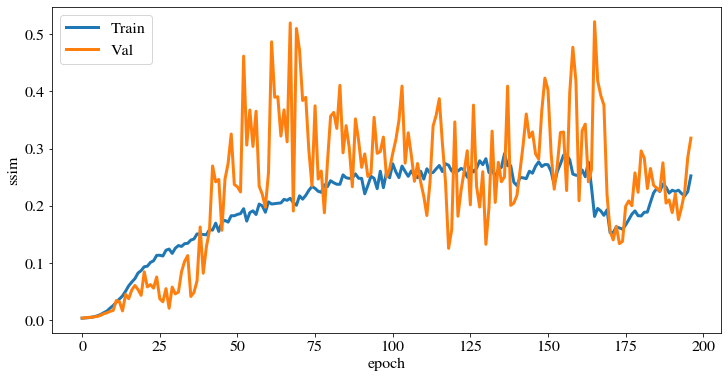

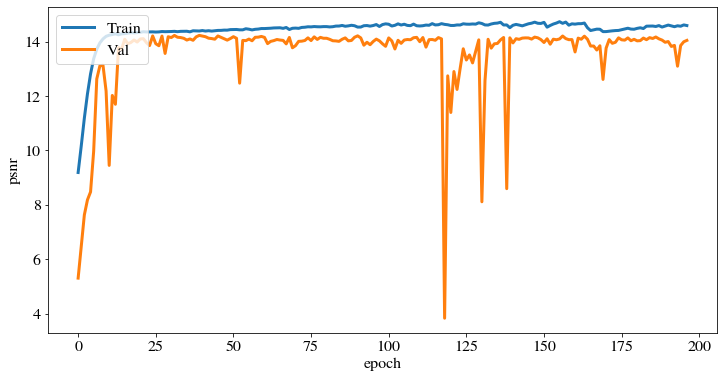

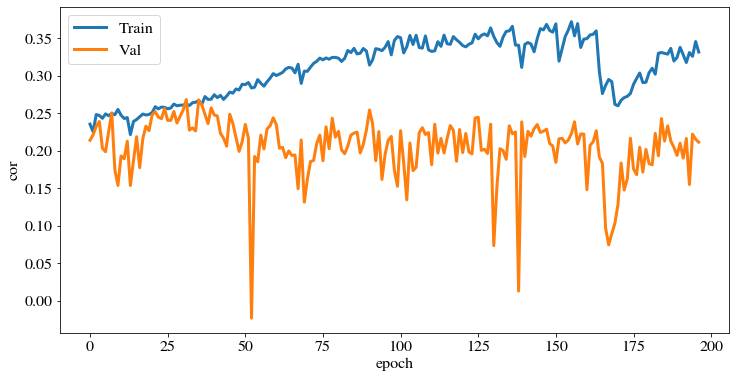

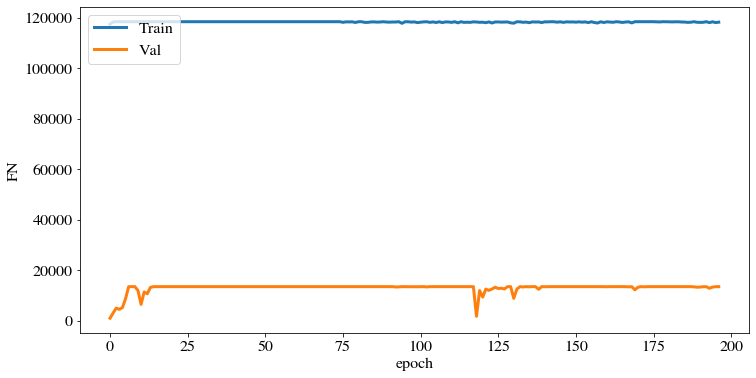

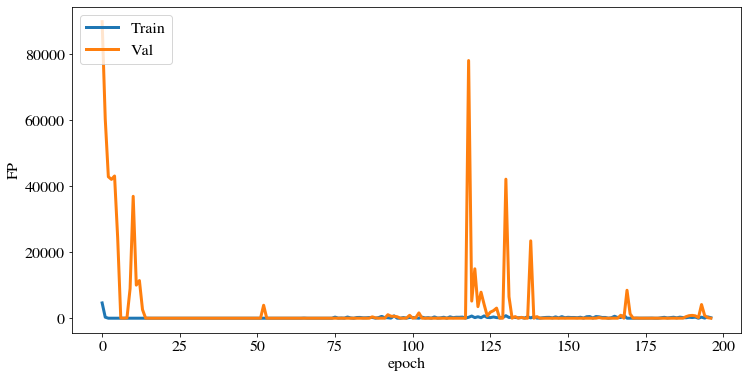

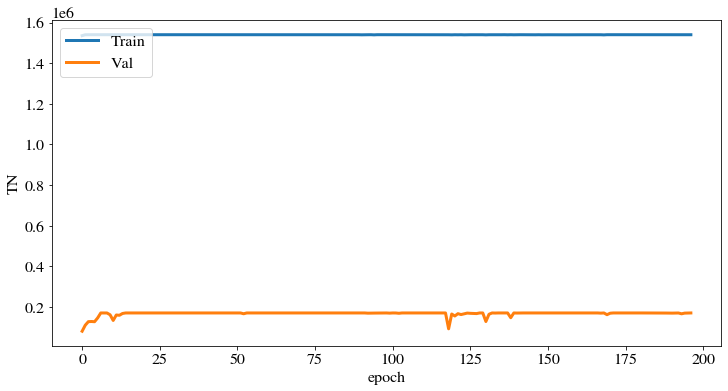

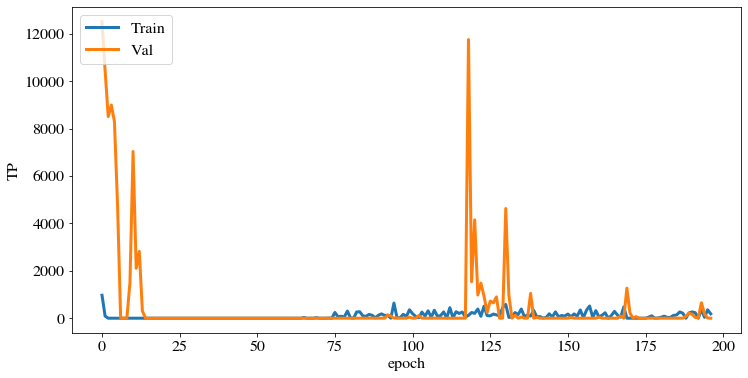

In [0]:
foldername = "".join(["/content/drive/My Drive/Results_project/Results_MNIST/Results_MCNet/", "loss_BCE_lr_1e-3_ELU_200epochs_BN_BS30_l2_0_001_Inception/"])
!mkdir "$foldername"

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'][3:], label='Train')
plt.plot(history.history['val_loss'][3:], label='Val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(left = 3)
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'loss.png']))
# files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'][3:], label='Train')
plt.plot(history.history['val_acc'][3:], label='Val')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.xlim(left = 3)
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'acc.png']))
# files.download('acc.png')

# plt.figure(figsize=(12,6))
# plt.plot(history.history['binary_accuracy'], label='Train')
# plt.plot(history.history['val_binary_accuracy'], label='Val')
# plt.ylabel('binary_accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='upper left')
# plt.savefig("".join([foldername,'binary_accuracy.png']))
# # files.download('binary_accuracy.png')
# #
# plt.figure(figsize=(12,6))
# plt.plot(history.history['cosine_similarity'], label='Train')
# plt.plot(history.history['val_cosine_similarity'], label='Val')
# plt.ylabel('cosine_similarity')
# plt.xlabel('epoch')
# plt.legend(loc='upper left')
# plt.savefig("".join([foldername,'cosine_similarity.png']))
# # files.download('cosine_similarity.png')

plt.figure(figsize=(12,6))
plt.plot(history.history['binary_crossentropy'][3:], label='Train')
plt.plot(history.history['val_binary_crossentropy'][3:], label='Val')
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
# plt.xlim(left = 3)
# plt.ylim(top = history.history['binary_crossentropy'][3])
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'binary_crossentropy.png']))
# files.download('binary_crossentropy.png')

# plt.figure(figsize=(12,6))
# plt.plot(history.history['logcosh'], label='Train')
# plt.plot(history.history['val_logcosh'], label='Val')
# plt.ylabel('logcosh')
# plt.xlabel('epoch')
# plt.legend(loc='upper left')
# plt.savefig("".join([foldername,'logcosh.png']))
# # files.download('logcosh.png')

plt.figure(figsize=(12,6))
plt.plot(history.history['mse'][3:], label='Train')
plt.plot(history.history['val_mse'][3:], label='Val')
plt.ylabel('mse')
plt.xlabel('epoch')
# plt.xlim(left = 3)
# plt.ylim(top = history.history['mse'][3])
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'mse.png']))
# files.download('mse.png')

plt.figure(figsize=(12,6))
plt.plot(history.history['prec'][3:], label='Train')
plt.plot(history.history['val_prec'][3:], label='Val')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'prec.png']))
# files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'][3:], label='Train')
plt.plot(history.history['val_recall'][3:], label='Val')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'recall.png']))

plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'][3:], label='Train')
plt.plot(history.history['val_ssim'][3:], label='Val')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'ssim.png']))
# files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'][3:], label='Train')
plt.plot(history.history['val_psnr'][3:], label='Val')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'psnr.png']))
# files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'][3:], label='Train')
plt.plot(history.history['val_cor'][3:], label='Val')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'cor.png']))
# files.download('cor.png')

plt.figure(figsize=(12,6))
plt.plot(history.history['FN'][3:], label='Train')
plt.plot(history.history['val_FN'][3:], label='Val')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'FN.png']))
# files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'][3:], label='Train')
plt.plot(history.history['val_FP'][3:], label='Val')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'FP.png']))
# files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'][3:], label='Train')
plt.plot(history.history['val_TN'][3:], label='Val')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'TN.png']))
# files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'][3:], label='Train')
plt.plot(history.history['val_TP'][3:], label='Val')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig("".join([foldername,'TP.png']))
# files.download('TP.png')


In [0]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 50
init_traj = 10
pred_traj = data.shape[1] - init_traj
track_MCNet_motion = X_MCNet_motion[itest, :, :, :, :]
track_MCNet_content = X_MCNet_content[itest, :, :, :]
track = data[itest, :init_traj, :, :, :]
print(track.shape)
print(track_MCNet_content.shape)
print(track_MCNet_motion.shape)
# for i in range(pred_traj):
for i in range(10):
  new_pos = model.predict([track_MCNet_motion[None, :, :, :, :], track_MCNet_content[None, :,:,:]])
  print(new_pos.shape)
  track = np.concatenate((track, new_pos), axis=0)
  track_MCNet_content = new_pos[0]
  track_MCNet_motion = np.concatenate((track_MCNet_motion, new_pos), axis=0)
  track_MCNet_motion[-1] = track_MCNet_motion[-1] - track_MCNet_motion[-2]
print("track:", track.shape)

(10, 64, 64, 1)
(64, 64, 1)
(9, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
track: (20, 64, 64, 1)


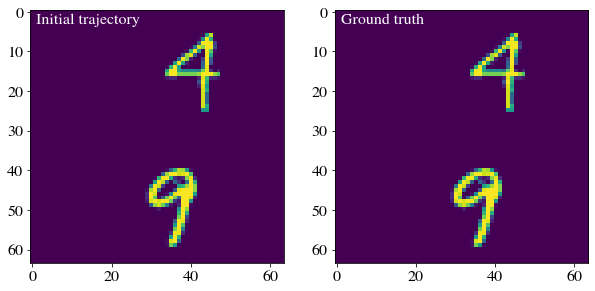

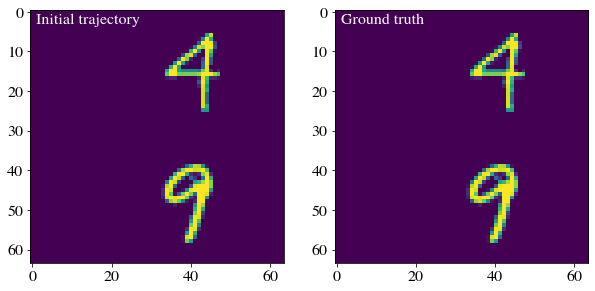

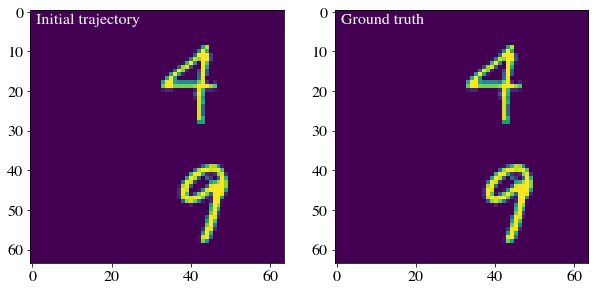

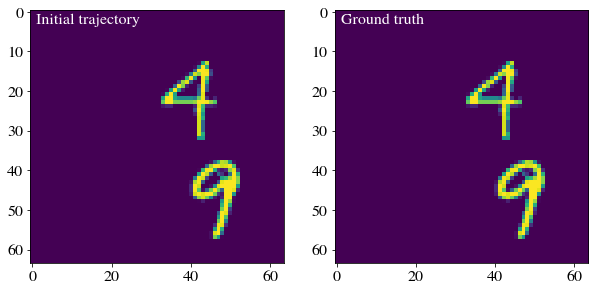

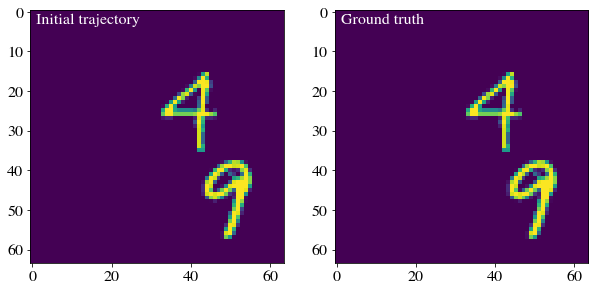

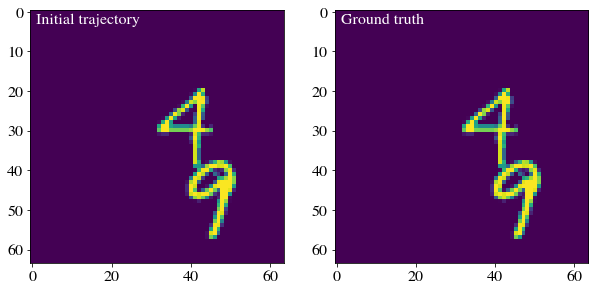

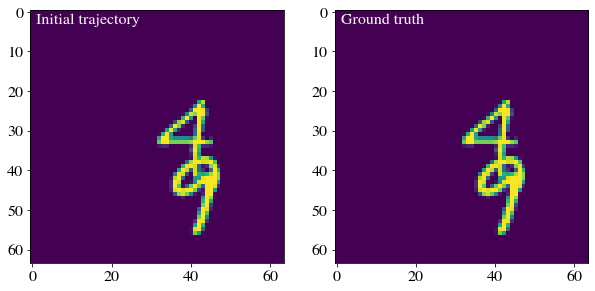

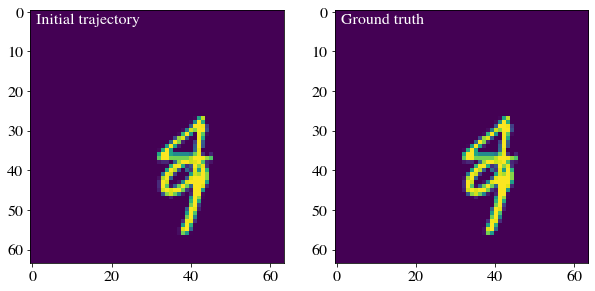

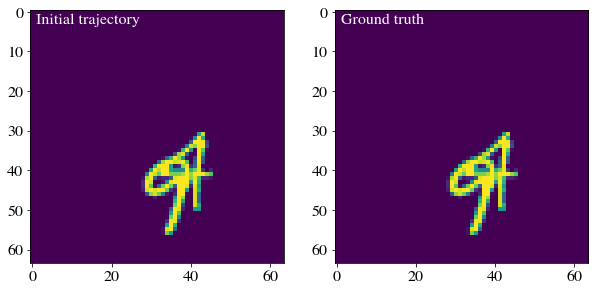

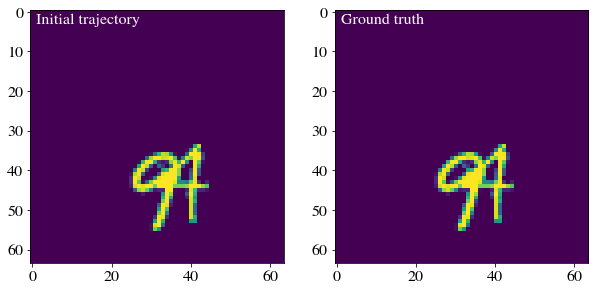

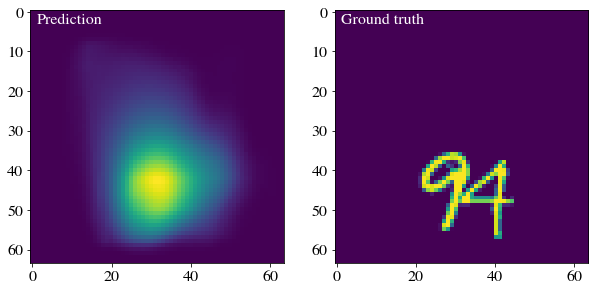

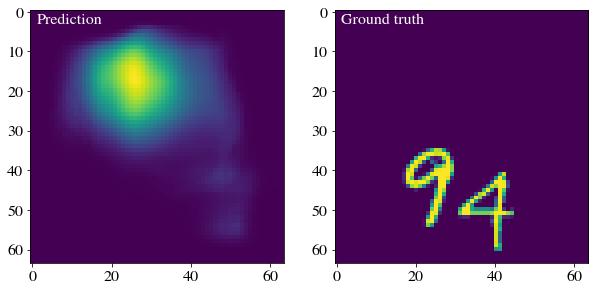

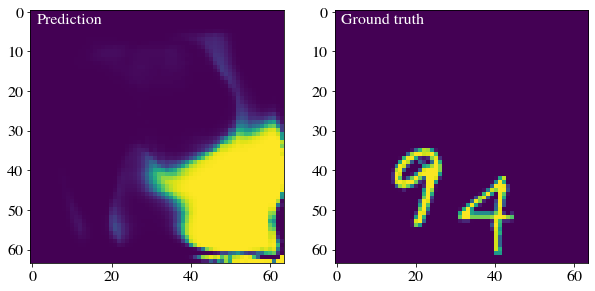

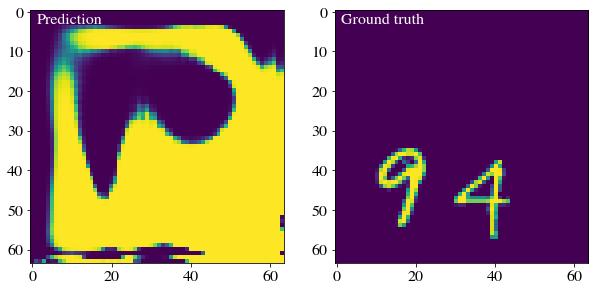

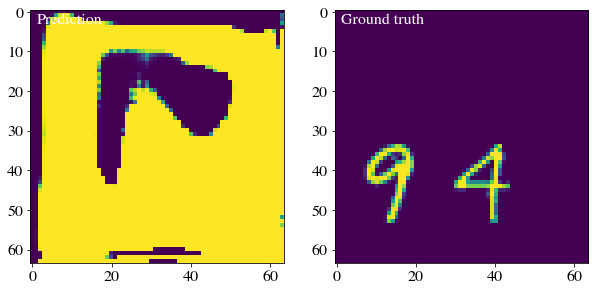

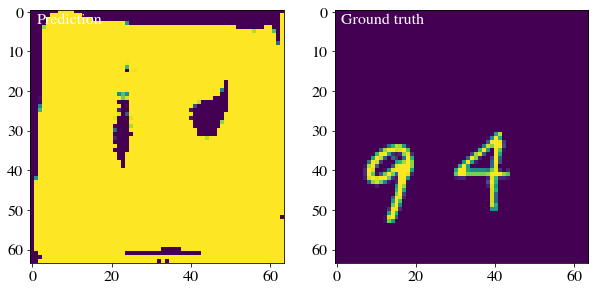

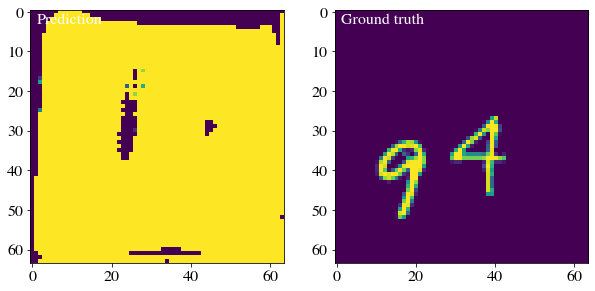

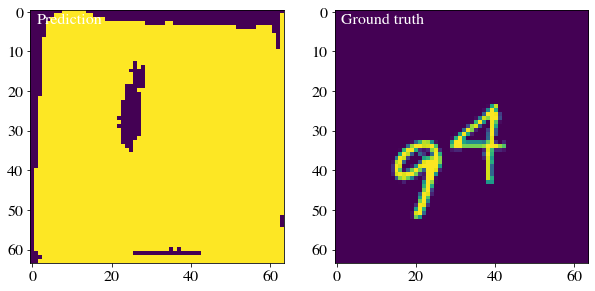

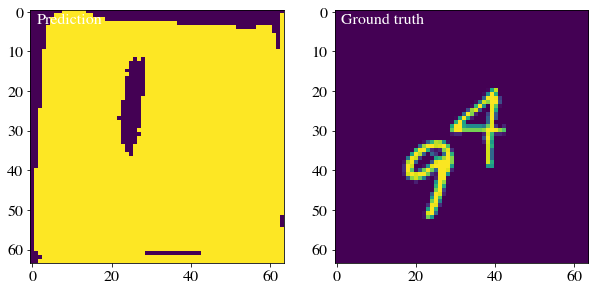

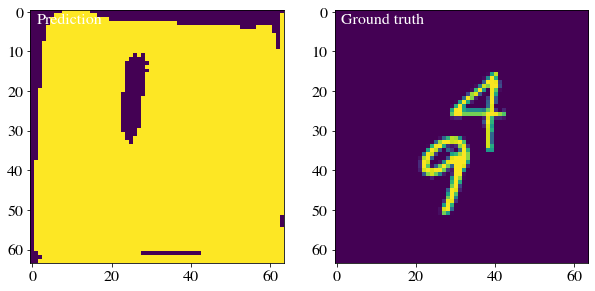

In [0]:
# Plot results
true_track = data[itest, :, :, :, 0]

for i in range(20):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= init_traj:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :])

    plt.savefig('anim_%i.png' % (i+1))
    #files.download('anim_%i.png' % (i+1))